# PySpark ML Project

## Brain Stroke Dataset

In this section of the reprot we will be exploring a dataset regarding brain strokes and attributes that can be effective in causing a brain strokes.

Attributes:
- gender : gendder of the individual
- age : age of the individual
- hypertension : whether a person has a high blood pressure **(0 = no, 1 = yes)**
- heart_disease : if an individual has heart disease **(0 = no, 1 = yes)**
- ever_married : whether an individual has ever been married **(0 = no, 1 = yes)**
- work_type : work_type of an individual **('Private', 'Self-employed', 'Govt_job', 'children')**
- Residence_type : where an individual lives **('Urban' or 'Rural')**
- average_glucose_level = average glucose level of an individual
- bmi = bmi of an individual
- smoking_status = an individfdual relationship with somking **(e.g 'formerly smoked', 'never smoked', 'smokes', 'Unknown')**

### Exploratory Analysis

We will begin by exploring the dataset

In [5]:
# importing the packages required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import os
import findspark
import py4j
from pyspark.sql import SparkSession

from pyspark.sql.types import *
from pyspark.sql.functions import mean,countDistinct, avg,stddev, col, count, when
import pyspark.sql.functions as F

from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #for plotting

## Initialising Pyspark

#### Importing findspark

In [6]:
import findspark
findspark.init()
findspark.find()

'C:\\spark-3.3.1-bin-hadoop2'

#### Creating SparkSession

In [7]:
spark = SparkSession.builder.appName('TheLab').getOrCreate()
spark

In [8]:
# Loading in the dataset brain_stroke.csv
# df_brain = pd.read_csv('brain_stroke.csv')

brain_df = spark.read.csv(path='brain_stroke.csv',inferSchema=True,header=True)
brain_df.show(5)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0|   never smoked|     1|
|  Male|81.0|           0|            0|         Yes|      Private|         Urban|           186.

### Create data dictionary

Creating a data dictionary of the attributes in the dataset

In [9]:
name = []
col_type = []
desc = ['gender of the individual', 'age of the individual', ' whether a person has a high blood pressure (0 = no, 1 = yes)', 'if an individual has heart disease (0 = no, 1 = yes)', 'whether an individual has ever been married (0 = no, 1 = yes)', 
"work type of an individual ('Private', 'Self-employed', 'Govt_job', 'children')", 
"where an individual lives ('Urban' or 'Rural')", 'average glucose level of an individual', 'bmi of an individual', "an individual relationship with somking (e.g 'formerly smoked', 'never smoked', 'smokes', 'Unknown')",'whether an individual had a stroke']

for a1 in brain_df.dtypes:
    name.append(a1[0])
    col_type.append(a1[1])

data_dictionary = {
    'Column_name' : name,
    'Column_type' : col_type,
    'Breif_description' : desc
}

data_dictionary = pd.DataFrame(data_dictionary)
data_dictionary

,Column_name,Column_type,Breif_description
0,gender,string,gender of the individual
1,age,double,age of the individual
2,hypertension,int,whether a person has a high blood pressure (0...
3,heart_disease,int,"if an individual has heart disease (0 = no, 1 ..."
4,ever_married,string,whether an individual has ever been married (0...
5,work_type,string,"work type of an individual ('Private', 'Self-e..."
6,Residence_type,string,where an individual lives ('Urban' or 'Rural')
7,avg_glucose_level,double,average glucose level of an individual
8,bmi,double,bmi of an individual
9,smoking_status,string,an individual relationship with somking (e.g '...


In [10]:
# Snippet of the data
brain_df.show(5)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0|   never smoked|     1|
|  Male|81.0|           0|            0|         Yes|      Private|         Urban|           186.

In [11]:
# Checking nulls in the data
brain_df.select([count(when(col(c).isNull(),c)).alias(c) for c in brain_df.columns]).show()

+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



We can see from the data that there are zero nulls in this dataset. This means we do not have to fill or remove any null data.

### Distribution of numerical variables

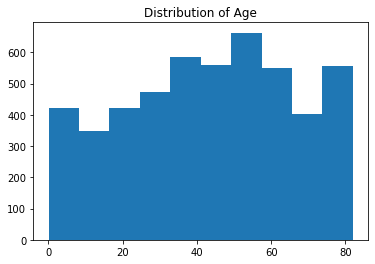

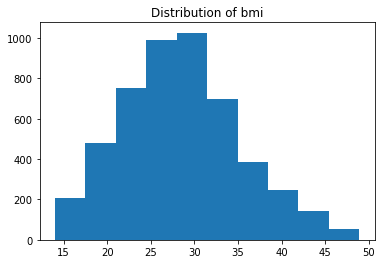

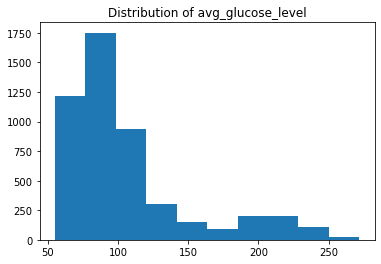

In [12]:
columns = ['Age','bmi','avg_glucose_level']

def pyspark_hist(column):
    values = []
    for age in brain_df.select(column).collect():
        values.append(age[0])
    plt.figure()
    plt.title(f'Distribution of {column}')
    plt.hist(values)
    plt.show()

for col in columns:
    pyspark_hist(col)

As we can see bmi and age look relatively normally distibuted. However, avg_glucose_level does not.

### Visualising the categorical variables

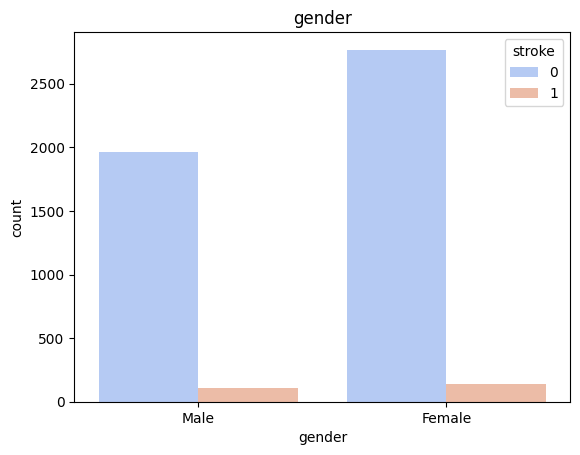

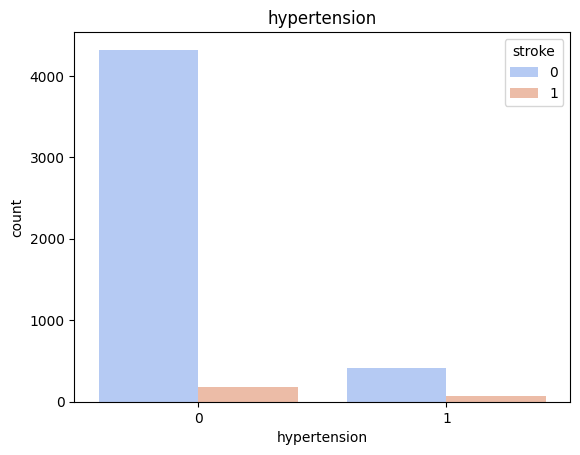

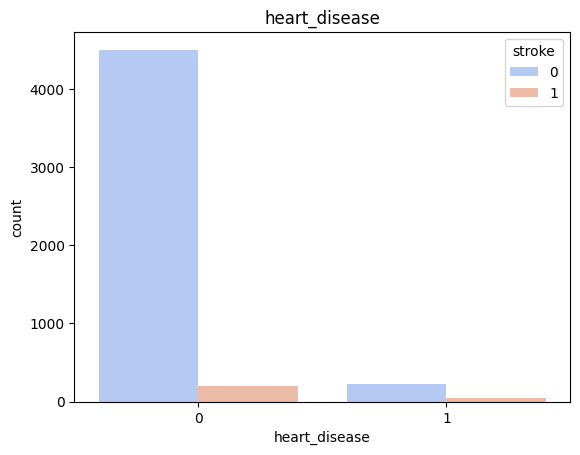

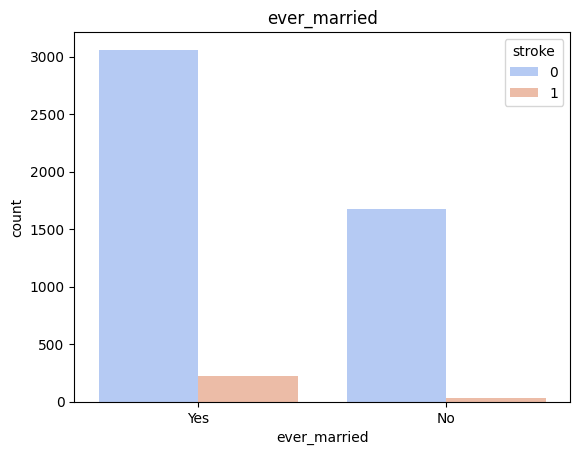

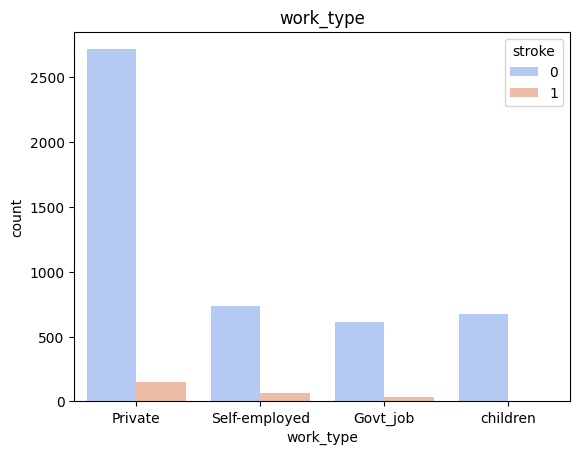

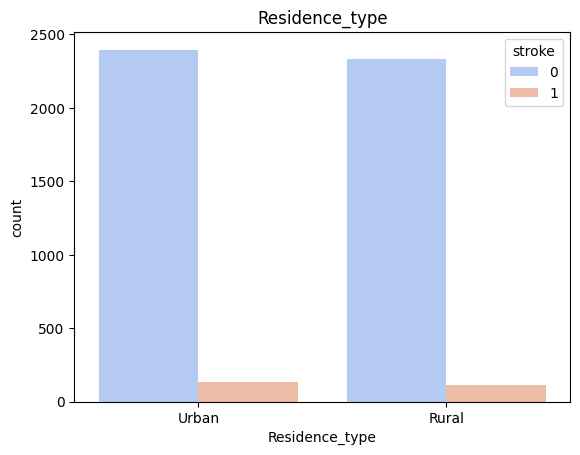

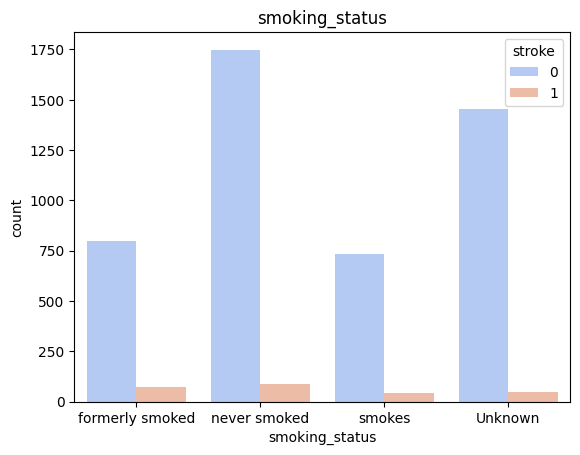

In [46]:
brain_df_viz = brain_df.toPandas()

categorical_variables = ['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status']

for i in range(len(categorical_variables)):
    plt.figure
    plt.title(categorical_variables[i])
    sns.countplot(data=brain_df_viz,x=categorical_variables[i],hue='stroke',palette='coolwarm')
    plt.show()

Above you can see a bar chart of all the categorical attributes in the dataset, split by whether an individual had a brain stoke or not. From the eye, it can be seen that the if an idvidual has been married there's a clear greater number of brain strokes. We will continue to look further into the continuous variables.

Another aspect of the data that can be observed is the number of Unknown variables in the smoker_status column.

This can be an issue as it can skew our data with variables that do not add any substance to our data.

### Analysing the smoker_status column in the dataset

In [47]:
# Length Of Dataset
length = brain_df.count()
print('Length of the dataset is:',brain_df.count())

# Number of rows with smoking status = Unknown
num_of_unknowns = brain_df.filter(brain_df.smoking_status == 'Unknown').count()
print('The number of entries with smoikng status equal to Unknown:',brain_df.filter(brain_df.smoking_status == 'Unknown').count())

print(f'This equates to: {round(num_of_unknowns/length * 100,2)}% of the dataset')


Length of the dataset is: 4981
The number of entries with smoikng status equal to Unknown: 1500
This equates to: 30.11% of the dataset


Although 1500 results is a lot of data and equates to about 30.1% of the entire dataset, it is necessary to remove these attributes as they will provide skewness in our model.

In [48]:
# Removing all the 'unknown' recorded values from the dataset
brain_df = brain_df.filter(brain_df.smoking_status != 'Unknown')

## Model Preparation

We will begin by preparing the data for our decison tree model and random forest model. In order to prepare the data we must one hot encode the categorical variables.

In [50]:
brain_df.show()


# categorical_variables = ['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status']
# prep_df = df
# display(prep_df.head())
# prep_df = pd.get_dummies(prep_df,columns=categorical_variables,drop_first=True)
# print(len(prep_df))
# prep_df.stroke.unique()

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0|   never smoked|     1|
|  Male|81.0|           0|            0|         Yes|      Private|         Urban|           186.

## Balancing the data

Before testing any models we must check the balance in our target variable, stroke.

As we can from the bar chart below we have a large imbalance in the data.

Text(0, 0.5, 'count')

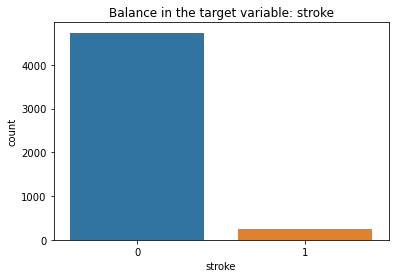

In [16]:
b_s_viz = brain_df.toPandas()
series = pd.DataFrame(b_s_viz['stroke'].value_counts()).reset_index()
plt.figure()
sns.barplot(data=series,x='index',y='stroke')
plt.title('Balance in the target variable: stroke')
plt.xlabel('stroke')
plt.ylabel('count')

In [17]:
# Splitting data into dataset variables and target variable (X and y) for our model
X = brain_df_viz.drop('stroke',axis=1)
y = brain_df_viz.stroke

In [13]:
from imblearn.under_sampling import RandomUnderSampler 
undersample = RandomUnderSampler(sampling_strategy = 'majority')
X_under, y_under = undersample.fit_resample(X,y)
print(len(y_under))
plt.hist(y_under)

NameError: name 'X' is not defined

We now how a balanced set of data with 402 data points. I chose to under sample the data as by oversampling we would be created over 2000 new data points which could implement bias into the model.

In [81]:
# Collecting all the data into a dataframe
X_under['stroke'] = y_under
model_df = X_under

# Converting it to PySpark
model_df = spark.createDataFrame(model_df)
model_df.show()

C:\spark-3.3.1-bin-hadoop2\python\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\spark-3.3.1-bin-hadoop2\python\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|61.0|           0|            0|         Yes|      Private|         Rural|           140.96|34.0|         smokes|     0|
|  Male|82.0|           0|            0|         Yes|Self-employed|         Urban|           111.81|19.8|formerly smoked|     0|
|Female|13.0|           0|            0|          No|      Private|         Rural|            60.69|24.0|         smokes|     0|
|Female|48.0|           0|            0|         Yes|Self-employed|         Rural|            71.93|41.7|   never smoked|     0|
|  Male|18.0|           0|            0|          No|      Private|         Urban|            97.

## Encoding the categorical variables

In [82]:
# model_df
categorical_variables = ['gender','ever_married','work_type','Residence_type','smoking_status']

from pyspark.ml.feature import StringIndexer
for var in categorical_variables:
    label_stringIdx = StringIndexer(inputCol = var, outputCol = f'labelIndex_{var}')
    model_df = label_stringIdx.fit(model_df).transform(model_df)
    model_df = model_df.drop(var)

model_df.show()

+----+------------+-------------+-----------------+----+------+-----------------+-----------------------+--------------------+-------------------------+-------------------------+
| age|hypertension|heart_disease|avg_glucose_level| bmi|stroke|labelIndex_gender|labelIndex_ever_married|labelIndex_work_type|labelIndex_Residence_type|labelIndex_smoking_status|
+----+------------+-------------+-----------------+----+------+-----------------+-----------------------+--------------------+-------------------------+-------------------------+
|61.0|           0|            0|           140.96|34.0|     0|              1.0|                    0.0|                 0.0|                      1.0|                      2.0|
|82.0|           0|            0|           111.81|19.8|     0|              1.0|                    0.0|                 1.0|                      0.0|                      1.0|
|13.0|           0|            0|            60.69|24.0|     0|              0.0|                    1.0|

### Scaling the data

In [94]:
# columns = model_df.columns
# del columns[5]
# print(columns)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# preparign the data for the model

assembler = VectorAssembler(inputCols=columns, outputCol="features")
model_df = assembler.transform(model_df)
# Standardizng the data with Min-max Scaling
model_df= MinMaxScaler(inputCol="features", outputCol="features_scaled").fit(model_df).transform(model_df)
model_df.show(5)

+----+------------+-------------+-----------------+----+------+-----------------+-----------------------+--------------------+-------------------------+-------------------------+--------------------+--------------------+
| age|hypertension|heart_disease|avg_glucose_level| bmi|stroke|labelIndex_gender|labelIndex_ever_married|labelIndex_work_type|labelIndex_Residence_type|labelIndex_smoking_status|            features|     features_scaled|
+----+------------+-------------+-----------------+----+------+-----------------+-----------------------+--------------------+-------------------------+-------------------------+--------------------+--------------------+
|61.0|           0|            0|           140.96|34.0|     0|              1.0|                    0.0|                 0.0|                      1.0|                      2.0|[61.0,0.0,0.0,140...|[0.70833333333333...|
|82.0|           0|            0|           111.81|19.8|     0|              1.0|                    0.0|           

#### Splitting the data

In [95]:
train, test = model_df.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 320
Test Dataset Count: 82


### Training the Random Forest model

In [97]:
from pyspark.ml.classification import RandomForestClassifier
# traing the Random Forest Model
rf = RandomForestClassifier(featuresCol = 'features_scaled', labelCol = 'stroke')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

### Random Forest Model Measurements

In [99]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Analysing the accraucy of the model
evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy = {accuracy}")
print(f"Test Error = {1.0 - accuracy}")

Accuracy = 0.7287715916672846
Test Error = 0.27122840833271544


### Training the Decision Tree Model

In [102]:
from pyspark.ml.classification import DecisionTreeClassifier
# traing the Random Forest Model
rf = DecisionTreeClassifier(featuresCol = 'features_scaled', labelCol = 'stroke')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

### Decision Tree Model Measurements

In [103]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Analysing the accraucy of the model
evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy = {accuracy}")
print(f"Test Error = {1.0 - accuracy}")

Accuracy = 0.6548002075765438
Test Error = 0.3451997924234562


# -------------------------------------- Airplane Data Starts here (not done yet) ------------------------------------

# Regression

In [80]:
# Imports
from datetime import date, timedelta, datetime

In this section we will be applying regression to the  'Airplane_Crashes_and_Fatalities_Since_1908.csv'

In [81]:
plane_df = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')

# We will drop the unnecessary columns like 'index' and 'summary'
plane_df.drop(columns = ['index', 'Summary'], inplace = True)
plane_df.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0


## Checking for null data
The shape of the data frame is **(5268,11)**

In [82]:
plane_df.isnull().sum()

Date               0
Time            2219
Location          20
Operator          18
Flight #        4199
Route           1706
Type              27
Registration     335
cn/In           1228
Aboard            22
Fatalities        12
Ground            22
dtype: int64

As you can see **Flight #** has a large number of nulls alongside **Time**, **Route** and **cm/In**

Since **Flight #** is mostly null values we will drop it from the dataset.

In [83]:
# Dropping the 'Flight #' column
plane_df.drop(columns = 'Flight #', inplace = True)

In [84]:
# Analysing some other columns
print(plane_df['cn/In'].nunique())
print(plane_df['Registration'].nunique())
print(plane_df['Route'].nunique())
print(plane_df['Location'].nunique())

3707
4905
3244
4303


Here we see that these columns have large amounts of unique elements and thus will not provide any relevance to the model. Therfore we will drop these columns from our dataset.

In [85]:
plane_df.drop(columns = ['Registration', 'cn/In', 'Location', 'Route'], inplace = True)
plane_df.head()

,Date,Time,Operator,Type,Aboard,Fatalities,Ground
0,09/17/1908,17:18,Military - U.S. Army,Wright Flyer III,2.0,1.0,0.0
1,07/12/1912,06:30,Military - U.S. Navy,Dirigible,5.0,5.0,0.0
2,08/06/1913,NaN,Private,Curtiss seaplane,1.0,1.0,0.0
3,09/09/1913,18:30,Military - German Navy,Zeppelin L-1 (airship),20.0,14.0,0.0
4,10/17/1913,10:30,Military - German Navy,Zeppelin L-2 (airship),30.0,30.0,0.0


In [86]:
# Changing the date column to a datetime variable
plane_df['Date'] =  pd.to_datetime(plane_df['Date'])

# Extracting the month
plane_df['Month'] = pd.DatetimeIndex(plane_df['Date']).month
# Extracting the year
plane_df['Year'] = pd.DatetimeIndex(plane_df['Date']).year

plane_df.head()

,Date,Time,Operator,Type,Aboard,Fatalities,Ground,Month,Year
0,1908-09-17,17:18,Military - U.S. Army,Wright Flyer III,2.0,1.0,0.0,9,1908
1,1912-07-12,06:30,Military - U.S. Navy,Dirigible,5.0,5.0,0.0,7,1912
2,1913-08-06,NaN,Private,Curtiss seaplane,1.0,1.0,0.0,8,1913
3,1913-09-09,18:30,Military - German Navy,Zeppelin L-1 (airship),20.0,14.0,0.0,9,1913
4,1913-10-17,10:30,Military - German Navy,Zeppelin L-2 (airship),30.0,30.0,0.0,10,1913


Now we have added these columns we can remove the original **Date** and **Time** columns

In [87]:
plane_df.drop(columns =['Date', 'Time'], inplace = True)
plane_df.head()

,Operator,Type,Aboard,Fatalities,Ground,Month,Year
0,Military - U.S. Army,Wright Flyer III,2.0,1.0,0.0,9,1908
1,Military - U.S. Navy,Dirigible,5.0,5.0,0.0,7,1912
2,Private,Curtiss seaplane,1.0,1.0,0.0,8,1913
3,Military - German Navy,Zeppelin L-1 (airship),20.0,14.0,0.0,9,1913
4,Military - German Navy,Zeppelin L-2 (airship),30.0,30.0,0.0,10,1913


In [88]:
# Checking the number of nulls left in the dataset
print(len(plane_df))
plane_df.isnull().sum()

5268


Operator      18
Type          27
Aboard        22
Fatalities    12
Ground        22
Month          0
Year           0
dtype: int64

In [89]:
# Removing the left of the NaN values
plane_df.dropna(subset=['Operator','Type','Aboard','Fatalities','Ground'],inplace = True)
plane_df.head()

,Operator,Type,Aboard,Fatalities,Ground,Month,Year
0,Military - U.S. Army,Wright Flyer III,2.0,1.0,0.0,9,1908
1,Military - U.S. Navy,Dirigible,5.0,5.0,0.0,7,1912
2,Private,Curtiss seaplane,1.0,1.0,0.0,8,1913
3,Military - German Navy,Zeppelin L-1 (airship),20.0,14.0,0.0,9,1913
4,Military - German Navy,Zeppelin L-2 (airship),30.0,30.0,0.0,10,1913


## Encoding

In [101]:
# Lets look into the operator column
print(plane_df.Operator.unique()[0:20])

# We can see from the results that there are two main Operator types either a Military Type Plane or a Consumer type plane

# Therefore we will label encode the Operator; military aircraft = 1
#                                              consumer aircraft = 0 


operator_type = [1 if 'military' in x.lower() else 0 for x in plane_df['Operator'] ]
print(operator_type[0:10])

plane_df['Operator'] = operator_type

['Military - U.S. Army' 'Military - U.S. Navy' 'Private'
 'Military - German Navy' 'Military - German Army'
 'US Aerial Mail Service' 'Aircraft Transport and Travel' 'By Air'
 'Latecoere Airlines' 'Handley Page Transport' 'Aeropostale'
 'Military - Royal Airship Works' 'Franco-Roumaine'
 'West Australian Airways' 'Military - U.S. Army Air Service'
 'Daimler Airways / Grands Express Aeriens' 'Vickers'
 'Cie des Messageries Aeriennes' 'Grands Express Aeriens' "Amee de l'Air"]
[1, 1, 0, 1, 1, 1, 1, 1, 1, 1]


In [102]:
# Lets look into the Type column
print(plane_df.Type.unique()[0:30])

# We can see from the results that there are two main Aircraft types either an Airship or a Plane

# Therefore we will label encode the Type; airship = 1
#                                          plane = 0 


aircraft_type = [1 if 'airship' in x.lower() else 0 for x in plane_df['Type'] ]
print(aircraft_type[0:10])

plane_df['Type'] = aircraft_type

['Wright Flyer III' 'Dirigible' 'Curtiss seaplane'
 'Zeppelin L-1 (airship)' 'Zeppelin L-2 (airship)'
 'Zeppelin L-8 (airship)' 'Zeppelin L-10 (airship)'
 'Schutte-Lanz S-L-10 (airship)' 'Zeppelin L-32 (airship)'
 'Zeppelin L-31 (airship)' 'Super Zeppelin (airship)'
 'Zeppelin L-34 (airship)' 'Airship' 'Schutte-Lanz S-L-9 (airship)'
 'Zeppelin L-22 (airship)' 'Zeppelin L-43 (airship)'
 'Zeppelin L-23 (airship)' 'Zeppelin L-44 (airship)'
 'Zeppelin L-59 (airship)' 'Zeppelin L-70 (airship)'
 'Zeppelin L-53 (airship)' 'De Havilland DH-4' 'Curtiss R-4LM'
 'De Havilland DH.4' 'Curtiss JN-4H' 'Armstrong-Whitworth F-K-8'
 'Junkers JL-6' 'Junkers F-13' 'Salmson 2-A-2' 'Breguet 14']
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]


## Visualisations

We will check to see if any of the continuous variables are normally distributed, and determine which type of scaling to use.

C:\Users\alope\AppData\Local\Temp\ipykernel_22264\4169682079.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plane_df[continuous[i]],kde=True)


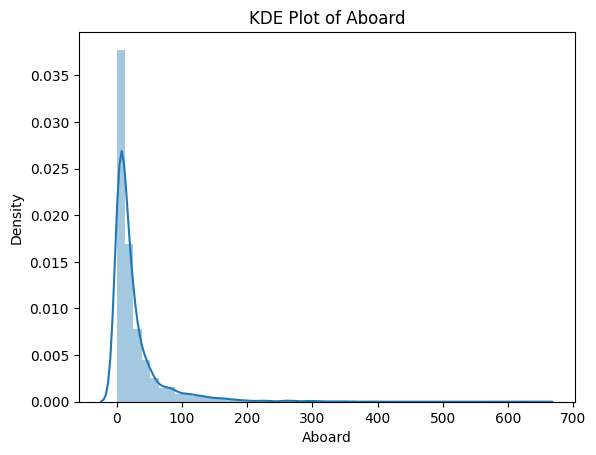

C:\Users\alope\AppData\Local\Temp\ipykernel_22264\4169682079.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plane_df[continuous[i]],kde=True)


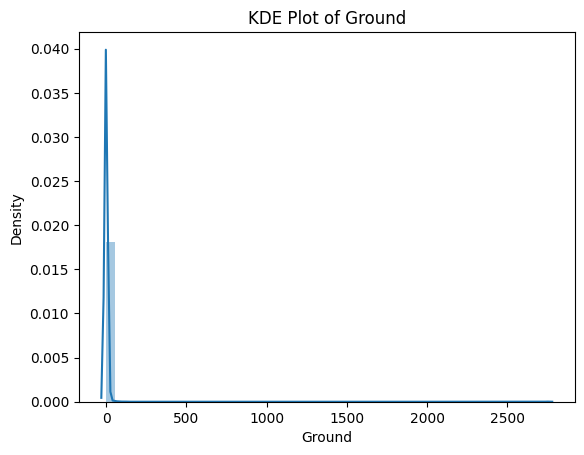

C:\Users\alope\AppData\Local\Temp\ipykernel_22264\4169682079.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plane_df[continuous[i]],kde=True)


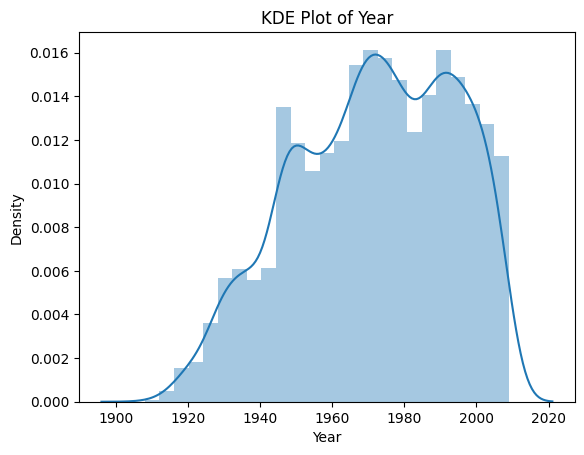

C:\Users\alope\AppData\Local\Temp\ipykernel_22264\4169682079.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plane_df[continuous[i]],kde=True)


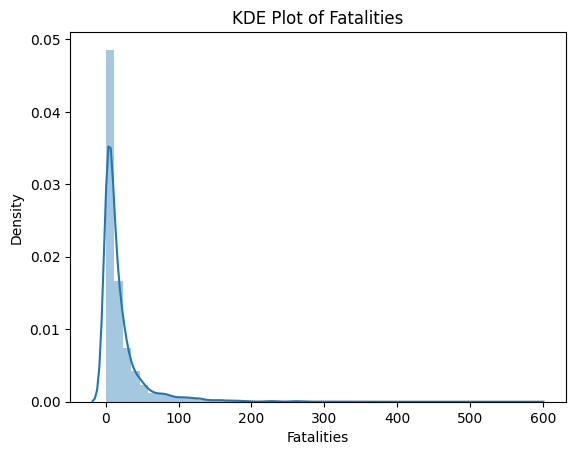

C:\Users\alope\AppData\Local\Temp\ipykernel_22264\4169682079.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plane_df[continuous[i]],kde=True)


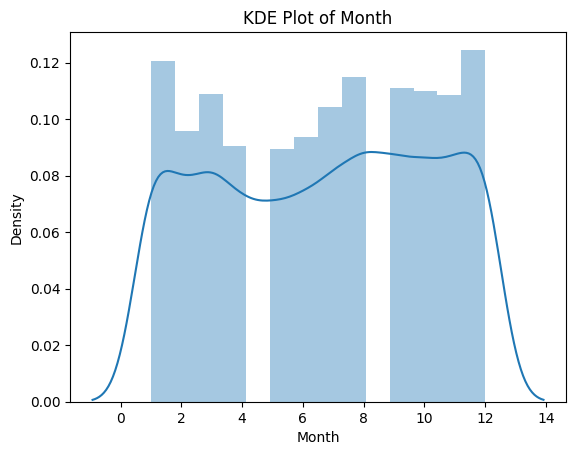

In [192]:
continuous = ['Aboard', 'Ground','Year','Fatalities', 'Month']

for i in range(len(continuous)):
    plt.figure()
    sns.distplot(plane_df[continuous[i]],kde=True)
    plt.title(f'KDE Plot of {continuous[i]}')
    plt.show()


As we can see from the graphs above the continuous variables are clearly not normally distributed. Therefore we will you Min-max scaling on this data.

## Visualisations Of Correlation

c:\Users\alope\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\alope\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\alope\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\alope\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\alope\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been as

<Figure size 640x480 with 0 Axes>

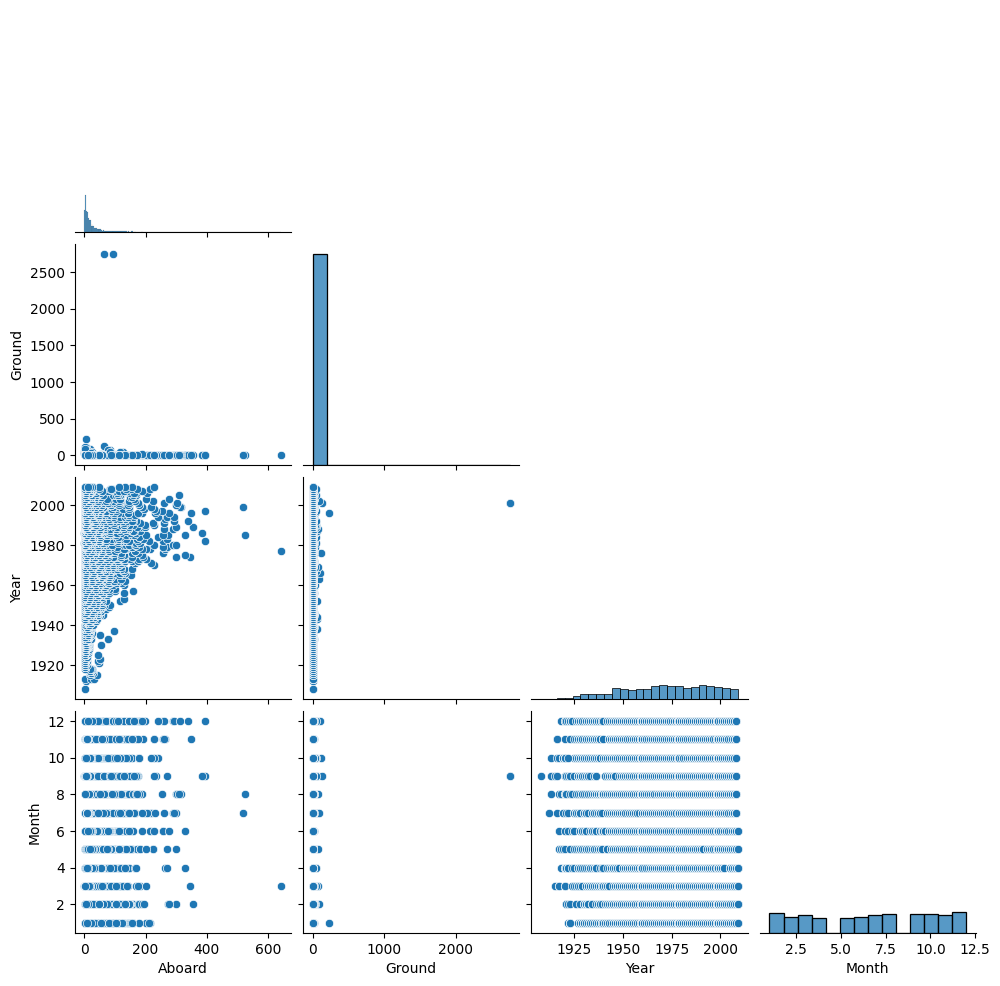

In [190]:
plt.figure()
sns.pairplot(plane_df[continuous],corner=True,palette='coolwarm')

Using this pairplot we can see the correlation between all the continuous variables. 

We can clearly see a postive correlation between **Aboard** and **Fatalities**

Text(0.5, 1.0, 'Correlation heatmap')

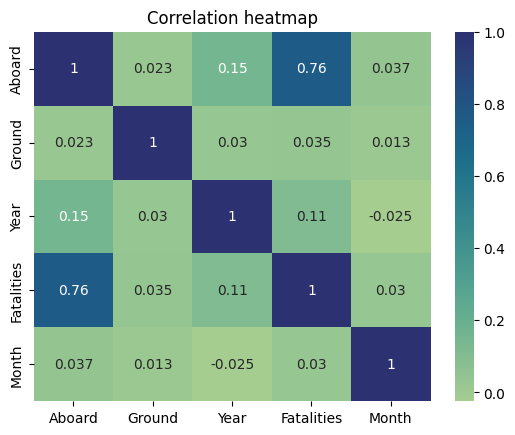

In [194]:
plt.figure()
sns.heatmap(plane_df[continuous].corr(),annot=True,cmap='crest')
plt.title('Correlation heatmap')

We can see this repeated in the heatmap above!

## Model Creation

Since we can see a clear correlation between **fatalities** and **abaord** we can produce a linear regression model with these attributes.

### Linear regression

In [196]:
X = plane_df['Aboard'].values.reshape(-1,1) # Attributes
y = plane_df['Fatalities'].values.reshape(-1,1) # target variable

from sklearn.preprocessing import MinMaxScaler
# Scaling the data wit MinMaxScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.35, random_state = 42)

In [197]:
from sklearn.linear_model import LinearRegression

regression = LinearRegression()
regression.fit(X_train,y_train)
y_pred = regression.predict(X_test)

### Visualising the Training set results

Text(0, 0.5, 'fatalities')

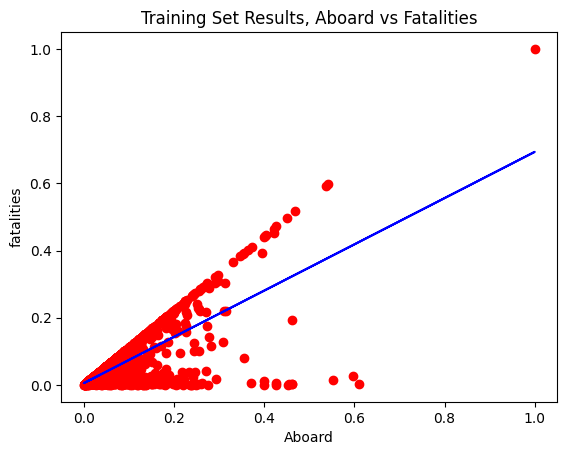

In [199]:
plt.scatter(X_train, y_train, color = 'r')
plt.plot(X_train, regression.predict(X_train), color = 'b')
plt.title('Training Set Results, Aboard vs Fatalities')
plt.xlabel('Aboard')
plt.ylabel('fatalities')

### Visualising the Test set results

Text(0, 0.5, 'fatalities')

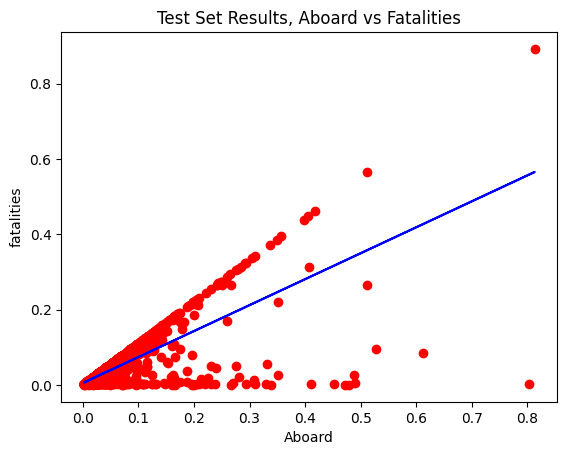

In [205]:
plt.scatter(X_test, y_test, color = 'r')
plt.plot(X_test, regression.predict(X_test), color = 'b')
plt.title('Test Set Results, Aboard vs Fatalities')
plt.xlabel('Aboard')
plt.ylabel('fatalities')

### Regression Score
We will now look at the regression score of our model

In [207]:
regression.score(X_test, y_test)

0.48930840009483734

### Measurements of the model

In [110]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.016948919052731347
MSE: 0.001656289501274021
RMSE:  0.040697536796150464


Chat about these results here...

### Coeficients and Intercept

In [111]:
regression.coef_, regression.intercept_

(array([[0.68829623]]), array([0.00531648]))

Our formula would be:

**Fatalities = (0.6883 * Aboard) + 0.00531648**

### Multiple Linear Regression

In this section we will apply multiple linear regression to our dataset

In [114]:
X = plane_df.drop(columns= 'Fatalities') # Attributes
y = plane_df['Fatalities'].values.reshape(-1,1) # target variable

from sklearn.preprocessing import MinMaxScaler
# Scaling the data wit MinMaxScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.35, random_state = 42)

In [120]:
multi_regression  = LinearRegression()
multi_regression.fit(X_train, y_train)
y_pred_mlr = multi_regression.predict(X_test)

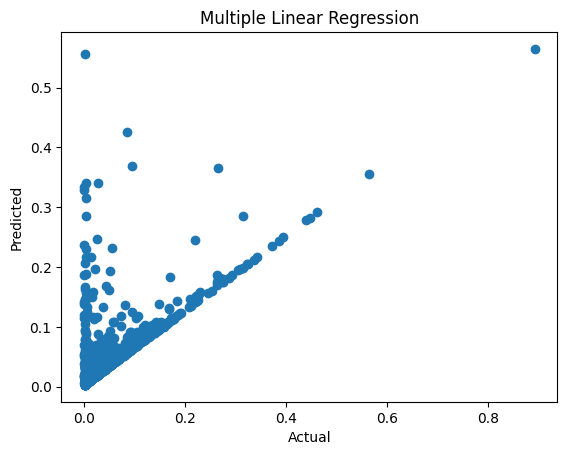

In [208]:
plt.scatter(y_test, y_pred_mlr)
plt.title('Multiple Linear Regression')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [122]:
multi_regression.score(X_test, y_test)

0.49452438414018607

In [123]:
print('MAE:' , metrics.mean_absolute_error(y_test, y_pred_mlr))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_mlr))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr)))

MAE: 0.016460716504121467
MSE: 0.0016393728736758227
RMSE: 0.040489169831892366


In [127]:
# Coefficients
print(multi_regression.coef_)
print(multi_regression.intercept_)
plane_df

[[ 0.00973439 -0.0026615   0.68929892  0.04733187  0.0018169  -0.00253867]]
[0.00447927]


,Operator,Type,Aboard,Fatalities,Ground,Month,Year
0,1,0,2.0,1.0,0.0,9,1908
1,1,0,5.0,5.0,0.0,7,1912
2,0,0,1.0,1.0,0.0,8,1913
3,1,1,20.0,14.0,0.0,9,1913
4,1,1,30.0,30.0,0.0,10,1913
...,...,...,...,...,...,...,...
5262,1,0,18.0,18.0,0.0,5,2009
5263,1,0,112.0,98.0,2.0,5,2009
5265,0,0,228.0,228.0,0.0,6,2009
5266,0,0,1.0,1.0,0.0,6,2009


The formula would be:

**Fatalities** = 0.00973439 * **Operator** + -0.0026615 * **Type** + 0.68929892 * **Aboard** + 0.04733187 * **Ground** + 0.0018169 * **Month** + -0.00253867 * **Year**  + 0.00447927

We can see by the coefficients that **Aboard** is the most dominant variable in our multiple regression model.

## Alternative Regression Methods

### Ridge Regression
In this section we will be applying ridge regression to our plane dataset

In [128]:
plane_df.head()

,Operator,Type,Aboard,Fatalities,Ground,Month,Year
0,1,0,2.0,1.0,0.0,9,1908
1,1,0,5.0,5.0,0.0,7,1912
2,0,0,1.0,1.0,0.0,8,1913
3,1,1,20.0,14.0,0.0,9,1913
4,1,1,30.0,30.0,0.0,10,1913


In [210]:
from sklearn.linear_model import Ridge

# Calling the Ridge function with alpha = 0
# Alpha is the penalty term that denotes the amount of constraint that will be implemented in the equation

ridge = Ridge(alpha=0) 
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

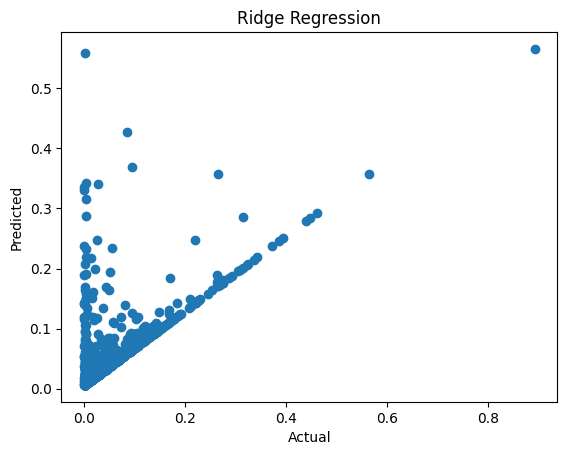

In [211]:
plt.scatter(y_test,y_pred_ridge)
plt.title('Ridge Regression')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [212]:
ridge.score(X_test, y_test)

0.489308400094838

In [136]:
print('MAE:' , metrics.mean_absolute_error(y_test, y_pred_ridge))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_ridge))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge)))

MAE: 0.016460716504121488
MSE: 0.0016393728736758214
RMSE:  0.040489169831892345


## Implementing k-Fold Cross-Validation
The k-fold cross-validation procedure divides our dataset into k non-overlapping folds. 

Each of the fold can be used as the test set and the mean performance of each run is reported.

To carry out k-Fold Cross-Validation we use the function;

RepeatedKFold(**n_splits** = number of folds , **n_repeats** = number of times we run the validation process)

We will use k-Fold Cross-Validation to find the optimal alpha value for our Ridge regression model

In [217]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

cross_valid = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Preparation to find the best alpha value
grid = dict()
grid['alpha'] = np.arange(0, 10, 0.1)

# Find the best alpha value based on the mean-absolute-error
search = GridSearchCV(ridge, grid, scoring='neg_mean_absolute_error', cv=cross_valid)
results = search.fit(X_train, y_train)

In [218]:
print('MAE:', results.best_score_)
print('Config:' ,results.best_params_)

MAE: -0.016113418422701937
Config: {'alpha': 0.0}


In [219]:
ridge.coef_

array([[0.68829623]])

We can see abovve that the best mean-squared-error was 0.01570 (ignore the negative sign as neg_mean_absolute_error was used to score the models), with an alpha value of 0.

This is exactly what we used previously.

### Lasso Regression

In this section we will apply Lasso Regression to our model and observe the effect onthe regression score.

Lasso regression is a regularization technique. It is used over regression methods for a more accurate prediction. This tyle of regression uses shrikage where data points are shrunk towards a central point as a the mean. Lasso regression encourages simpler models (models with fewer parameters)

With Lasso Regression we do **not** standardize the data

In [162]:
from sklearn.linear_model import Lasso

X = plane_df.drop(columns= 'Fatalities') # Attributes
y = plane_df['Fatalities'].values.reshape(-1,1) # target variable

from sklearn.preprocessing import MinMaxScaler
# Scaling the data wit MinMaxScaler()
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)
# y_scaled = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state = 42)

lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

Text(0, 0.5, 'Predicted')

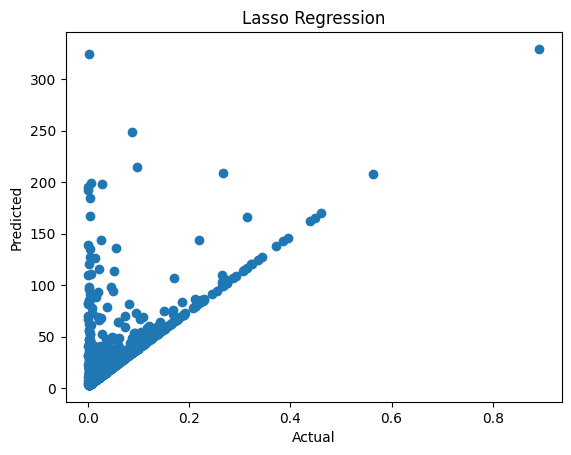

In [221]:
plt.scatter(y_test, y_pred_lasso)
plt.title('Lasso Regression')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [164]:
lasso.score(X_test, y_test)

0.48980237298917806

In [165]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_lasso))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_lasso))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso)))

MAE: 9.889469583275474
MSE: 562.4100573749673
RMSE: 23.71518621843327


In [168]:
print(lasso.coef_)
plane_df.head()

[ 0.00000000e+00  0.00000000e+00  6.23084218e-01  9.79432791e-03
  5.72883924e-04 -1.35000587e-02]


,Operator,Type,Aboard,Fatalities,Ground,Month,Year
0,1,0,2.0,1.0,0.0,9,1908
1,1,0,5.0,5.0,0.0,7,1912
2,0,0,1.0,1.0,0.0,8,1913
3,1,1,20.0,14.0,0.0,9,1913
4,1,1,30.0,30.0,0.0,10,1913
